2024-08-04 15:26:28.552375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 15:26:28.552502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 15:26:28.703228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


It: 0, Loss: 4.552e+04, Y0: 2.995, Time: 21.66, Total Time: 21.66, Learning Rate: 1.000e-03
It: 100, Loss: 1.403e+03, Y0: -0.003, Time: 8.56, Total Time: 30.22, Learning Rate: 1.000e-03
It: 200, Loss: 9.294e+02, Y0: -0.009, Time: 8.60, Total Time: 38.82, Learning Rate: 1.000e-03
It: 300, Loss: 6.944e+02, Y0: 0.044, Time: 8.71, Total Time: 47.53, Learning Rate: 1.000e-03
It: 400, Loss: 6.115e+02, Y0: -0.020, Time: 8.59, Total Time: 56.13, Learning Rate: 1.000e-03
It: 500, Loss: 5.350e+02, Y0: 0.012, Time: 8.54, Total Time: 64.66, Learning Rate: 1.000e-03
It: 600, Loss: 5.086e+02, Y0: 0.015, Time: 8.68, Total Time: 73.35, Learning Rate: 1.000e-03
It: 700, Loss: 4.814e+02, Y0: 0.049, Time: 8.58, Total Time: 81.93, Learning Rate: 1.000e-03
It: 800, Loss: 4.611e+02, Y0: 0.012, Time: 8.56, Total Time: 90.49, Learning Rate: 1.000e-03
It: 900, Loss: 4.537e+02, Y0: 0.018, Time: 8.55, Total Time: 99.04, Learning Rate: 1.000e-03
It: 1000, Loss: 4.510e+02, Y0: 0.032, Time: 8.70, Total Time: 107.75

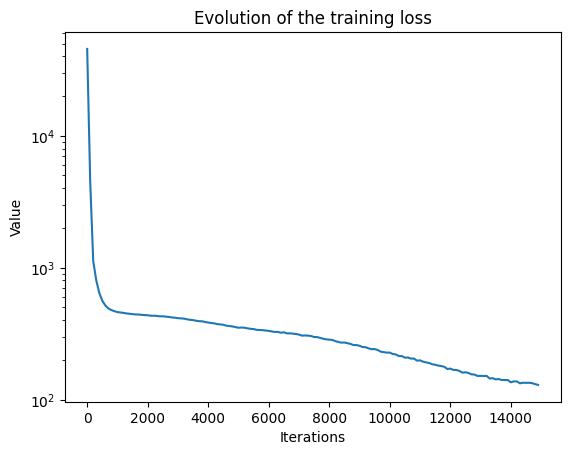

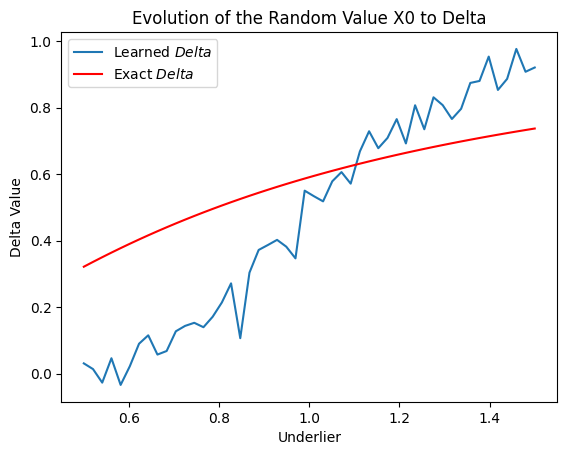

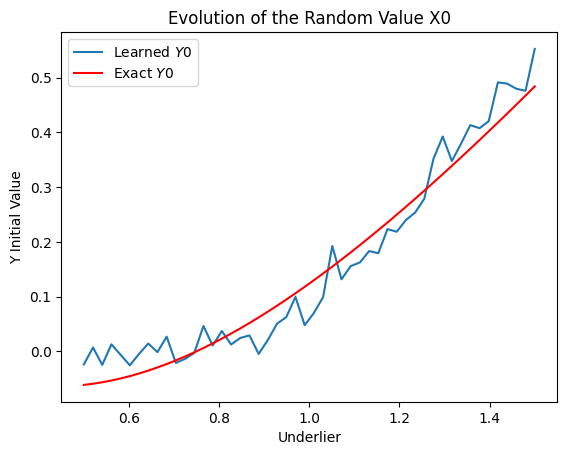

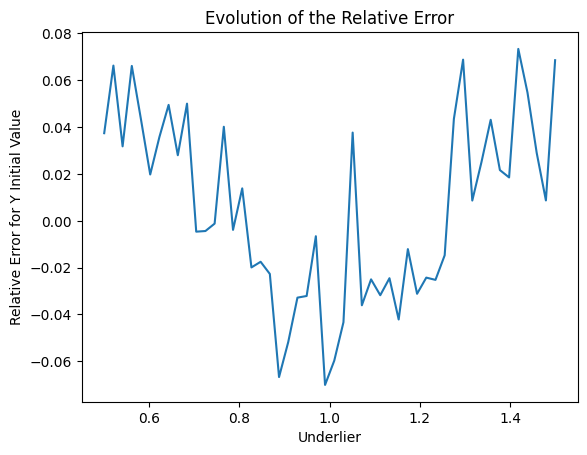

In [1]:
# basic imports
import os, random
import numpy as np
import datetime as dt
import time
from abc import ABC, abstractmethod
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt

from numpy import *
from scipy.stats import norm
# warnings
import warnings

warnings.filterwarnings('ignore')

# tensorflow
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

tf.keras.backend.clear_session()

from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout, Dense, Flatten, Layer, Add



class Linear(Layer):
    """Define Linear layers"""

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        self.in_dims = in_features
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'
        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    #@tf.function
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class StableLinear(Layer):
    """Define Stable Linear layers"""

    def __init__(self, in_features, out_features):
        super(StableLinear, self).__init__()

        self.epsilon = 0.01
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'

        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    def call(self, inputs):
        w = self.weight_constraint(self.w)
        return tf.matmul(inputs, w) + self.b

    def weight_constraint(self, weight):
        delta = 1 - 2 * self.epsilon
        RtR = tf.matmul(tf.transpose(weight), weight)
        norm = tf.norm(RtR)

        #if norm > delta: RtR = delta ** (1 / 2) * RtR / (norm ** (1 / 2))
        RtR_new = tf.sqrt(delta) * RtR / tf.sqrt(norm)
        RtR_update = tf.minimum(RtR_new, RtR)
        A = RtR_update + tf.eye(RtR.shape[0]) * self.epsilon
        return -A


class NaisNet(Model):
    """ Building NAIS_Net network using keras """

    def __init__(self, layers):
        super(NaisNet, self).__init__()

        self.layer1 = Linear(layers[0], layers[1])

        self.layer2 = StableLinear(layers[1], layers[2])
        self.layer2_input = Linear(layers[0], layers[2])

        self.layer3 = StableLinear(layers[2], layers[3])
        self.layer3_input = Linear(layers[0], layers[3])

        self.layer4 = StableLinear(layers[3], layers[4])
        self.layer4_input = Linear(layers[0], layers[4])

        self.layer5 = Linear(layers[4], layers[5])

    # Building block for the NAIS-Net
    def call(self, x):
        """Process stages in the block"""

        u = x

        output = self.layer1(u)  # layer 1
        output = tf.sin(output)

        X1 = output
        output = self.layer2(output)  # layer 2
        output = Add()([self.layer2_input(u), output])
        output = tf.sin(output)
        output = Add()([X1, output])

        X2 = output
        output = self.layer3(output)  # layer 3
        output = Add()([self.layer3_input(u), output])
        output = tf.sin(output)
        output = Add()([X2, output])

        X3 = output
        output = self.layer4(output)  # layer 4
        output = Add()([self.layer4_input(u), output])
        output = tf.sin(output)
        output = Add()([X3, output])

        output = self.layer5(output)  # layer 5

        return output

class FBSNN(ABC):
    """Forward-Backward SDEs using NAIS-Net """

    def __init__(self, Xi, T, M, N, D, layers):

        self.Xi = Xi  # initial point

        self.T = T  # terminal time
        self.M = M  # number of trajectories
        self.N = N  # number of time snapshots
        self.D = D  # number of dimensions

        # Initialize NN
        self.model = NaisNet(layers)

        # Record the loss
        self.training_loss = []
        self.iteration = []
        self.Y0_iter = []
        self.Z0_iter = []

    @tf.function
    def net_u(self, t, X):  # M x 1, M x D

        u = self.model(tf.concat([t, X], 1))  # M x 1
        Du = tf.gradients(u, X)[0]  # M x D

        return u, Du

    @tf.function
    def Dg_tf(self, X):  # M x D
        return tf.gradients(self.g_tf(X), X)[0]  # M x D

    def loss_function(self, t, W, Xi):

        loss = 0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:, 0, :]
        W0 = W[:, 0, :]

        X0 = tf.tile(Xi, [self.M, 1])  # M x D
        Y0, Z0 = self.net_u(t0, X0)  # M x 1, M x D

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        for n in range(0, self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]
            X1 = X0 + self.mu_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.squeeze(
                tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1)), axis=[-1])
            #Y1_tilde = Y0 + self.phi_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.reduce_sum(
                #Z0 * tf.squeeze(tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1))), axis=1,
                #keepdims=True)
            Y1_tilde = Y0 + self.phi_tf(t0, X0, Y0, Z0) * (t1 - t0) + Z0 * tf.squeeze(tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1)))
            Y1, Z1 = self.net_u(t1, X1)

            loss += tf.reduce_sum(tf.pow(Y1 - Y1_tilde, 2))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)

        loss += tf.reduce_sum(tf.pow(Y1 - self.g_tf(X1), 2))
        loss += tf.reduce_sum(tf.pow(Z1 - self.Dg_tf(X1), 2))

        X = tf.stack(X_list, axis=1)
        Y = tf.stack(Y_list, axis=1)
        Z = tf.stack(Z_list, axis=1)
        Y0 = tf.reduce_mean(Y, axis=0)

        return loss, X, Y, Y0[0, 0], Z

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M, N + 1, 1))  # M x (N+1) x 1
        DW = np.zeros((M, N + 1, D))  # M x (N+1) x D

        dt = T / N

        Dt[:, 1:, :] = dt
        DW[:, 1:, :] = np.sqrt(dt) * np.random.normal(size=(M, N, D))

        t = np.cumsum(Dt, axis=1)  # M x (N+1) x 1
        W = np.cumsum(DW, axis=1)  # M x (N+1) x D

        return t, W

    @tf.function
    def train_step(self, optimizers, t, winner, Xi):
        # Optimizers
        optimizer = optimizers

        with tf.GradientTape() as tape:
            loss_value, X_pred, Y_pred, Y0_pred, Z_pred = self.loss_function(t, winner, Xi)

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        return loss_value, Y0_pred, Z_pred

    def train(self, N_Iter, learning_rate):

        loss_temp = np.array([])
        Y0_pred_temp = np.array([])
        Z0_pred_temp = np.array([])
        # Optimizers
        self.optimizer = Adam(learning_rate=learning_rate)

        start_time = time.time()
        ini_time = time.time()

        for it in range(N_Iter):


          t_batch, W_batch = self.fetch_minibatch()  # M x (N+1) x 1, M x (N+1) x D
          t_batch = tf.convert_to_tensor(t_batch, dtype=tf.float32)
          W_batch = tf.convert_to_tensor(W_batch, dtype=tf.float32)
          self.Xi = tf.convert_to_tensor(self.Xi, dtype=tf.float32)

          loss_value, Y0_pred, Z_pred = self.train_step(self.optimizer, t_batch, W_batch, self.Xi)

          if it % 100 == 0:
              elapsed = time.time() - start_time
              total_time = time.time() - ini_time
              print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Total Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_pred, elapsed, total_time, learning_rate))
              start_time = time.time()

          loss_temp = np.append(loss_temp, loss_value.numpy())
          Y0_pred_temp = np.append(Y0_pred_temp, Y0_pred.numpy())

          Z0 = tf.reduce_mean(Z_pred, axis=0)
          Z0_pred_temp = np.append(Z0_pred_temp, Z0.numpy()[-1, :])


          if it % 100 == 0:
            self.training_loss.append(loss_temp[-100:].mean())
            self.Y0_iter.append(Y0_pred_temp[-100:].mean())
            self.Z0_iter.append(Z0_pred_temp[-100:].mean())
            self.iteration.append(it)

          graph = np.stack((self.iteration, self.training_loss))
          Y0_iter = np.stack((self.iteration, self.Y0_iter))
          Z0_iter = np.stack((self.iteration, self.Z0_iter))

        return graph, Y0_iter, Z0_iter


    def predict(self, Xi_star, t_star, W_star):
        t_star = tf.convert_to_tensor(t_star, dtype=tf.float32)
        W_star = tf.convert_to_tensor(W_star, dtype=tf.float32)
        Xi_star = tf.convert_to_tensor(Xi_star, dtype=tf.float32)

        loss, X_star, Y_star, Y0_pred, Z_pred = self.loss_function(t_star, W_star, Xi_star)

        return X_star, Y_star, Z_pred

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        pass  # M x1

    @abstractmethod
    def g_tf(self, X):  # M x D
        pass  # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M, D])  # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y):  # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M, D]))  # M x D x D
    ###########################################################################


class BlackScholes(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers):
        super().__init__(Xi, T, M, N, D, layers)

    def phi_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        return 0.05*Y # M x 1

    def g_tf(self, X):  # M x D
        K = 1.0
        X0 = np.array([1.0]*self.D)[None, :]
        X0 = tf.convert_to_tensor(X0, dtype=tf.float32)
        X0 = tf.tile(X0, [self.M, 1])  # M x D
        return tf.maximum(X-K*X0, 0) # M x 1

    def mu_tf(self, t, X, Y, Z):  # M x 1, M x D, M x 1, M x D
        return 0.05*X  # M x D

    def sigma_tf(self, t, X, Y):  # M x 1, M x D, M x 1
        return 0.4*tf.linalg.diag(X)# M x D x D

    ###########################################################################



if __name__ == "__main__":
    M = 100  # number of trajectories (batch size)
    N = 48  # number of time snapshots
    D = 50  # number of dimensions

    layers = [D+1] + 4 * [256] + [D]

    Xi = np.linspace(0.5, 1.5, D)
    Xi = np.array(Xi)[None, :]
    T = 0.5


    model = BlackScholes(Xi, T, M, N, D, layers)

    graph, Y0_iter, Z0_iter = model.train(15*10**3, 1e-3)

    np.random.seed(42)
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)
    Y_pred = np.mean(Y_pred, axis=0)
    Z_pred = np.mean(Z_pred, axis=0)



    def u_exact(t, X):  # (N+1) x 1, (N+1) x D

        r = 0.05
        sigma_max = 0.4
        K = 1.0
        X0 = 1.0
        E = K*X0
        a = sigma_max * (t**0.5)
        d1 = log(X/E) + (r + 0.5 * sigma_max**2) * t / a
        d2 = d1 - a
        payoff = X * norm.cdf(d1) - E * e**(-r * t) * norm.cdf(d2)
        delta = norm.cdf(d1)
        return payoff, delta

    Y0_test, _del = u_exact(T, Xi)

    plt.figure()
    plt.plot(graph[0], graph[1])
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    plt.yscale("log")
    plt.title('Evolution of the training loss')
    plt.savefig(str(D) + 'train-loss_1')

    plt.figure()
    plt.plot(Xi.T, Z_pred[-1,:].T, label='Learned $Delta$')
    plt.plot(Xi.T, _del.T, color='r', label='Exact $Delta$')
    plt.xlabel('Underlier')
    plt.ylabel('Delta Value')
    plt.legend()
    plt.title('Evolution of the Random Value X0 to Delta')
    plt.savefig(str(D) + ' Random X0_Delta_1')

    plt.figure()
    plt.plot(Xi.T, Y_pred[0,:].T, label='Learned $Y0$')
    plt.plot(Xi.T, Y0_test.T, color='r', label='Exact $Y0$')
    plt.xlabel('Underlier')
    plt.ylabel('Y Initial Value')
    plt.legend()
    plt.title('Evolution of the Random Value X0')
    plt.savefig(str(D) + ' Random X0_1')

    error = Y_pred[0,:] - Y0_test

    plt.figure()
    plt.plot(Xi.T, error.T)
    plt.xlabel('Underlier')
    plt.ylabel('Relative Error for Y Initial Value')
    #plt.yscale("log")
    plt.title('Evolution of the Relative Error')
    plt.savefig(str(D) + ' Error')

In [2]:
  np.random.seed(42)
  t_test, W_test = model.fetch_minibatch()
  X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)

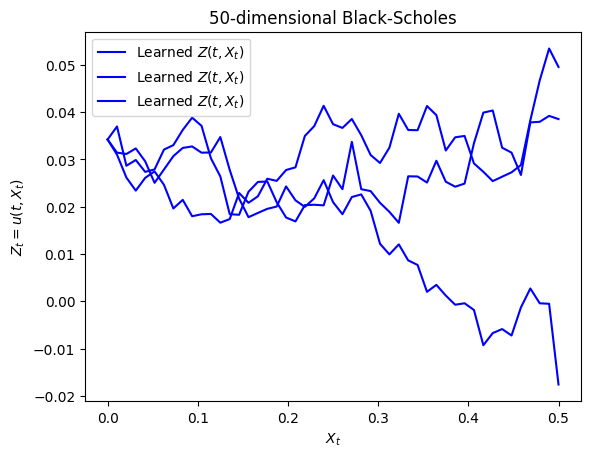

In [ ]:
plt.figure()
plt.plot(t_test[0:3, :, 0].T, Z_pred[0:3, :, 0].T, 'b', label='Learned $Z(t,X_t)$')

plt.xlabel('$X_t$')
plt.ylabel('$Z_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes')
plt.legend()
plt.savefig(str(D) + '-dimensional Z-trace')

In [ ]:
Y_pred_mean = np.mean(Y_pred, axis=0)
Y_pred_std = np.std(Y_pred, axis=0)

In [ ]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tabulate import tabulate
table = {'Xi': Xi.T, 'Y0_mean': Y_pred_mean[0, :].tolist(), 'Y0_std': Y_pred_std[0, :].tolist(), "Y0_exact": Y0_test.T}
print(tabulate(table, headers='keys', tablefmt='github'))

|       Xi |     Y0_mean |      Y0_std |    Y0_exact |
|----------|-------------|-------------|-------------|
| 0.5      | -0.023951   | 3.1665e-08  | -0.0613748  |
| 0.520408 |  0.00705124 | 5.58794e-09 | -0.0592422  |
| 0.540816 | -0.0247522  | 1.49012e-08 | -0.0565572  |
| 0.561224 |  0.0128113  | 0           | -0.0533298  |
| 0.581633 | -0.00635741 | 8.84756e-09 | -0.0495712  |
| 0.602041 | -0.0255073  | 9.31323e-09 | -0.045293   |
| 0.622449 | -0.00470747 | 6.51926e-09 | -0.0405076  |
| 0.642857 |  0.0142868  | 6.51926e-09 | -0.0352277  |
| 0.663265 | -0.00145819 | 9.31323e-10 | -0.0294663  |
| 0.683673 |  0.0268     | 5.58794e-09 | -0.0232364  |
| 0.704082 | -0.0211791  | 1.49012e-08 | -0.0165512  |
| 0.72449  | -0.0137806  | 6.51926e-09 | -0.00942377 |
| 0.744898 | -0.00306191 | 4.42378e-09 | -0.00186707 |
| 0.765306 |  0.0462753  | 1.49012e-08 |  0.00610602 |
| 0.785714 |  0.0106261  | 1.58325e-08 |  0.0144829  |
| 0.806122 |  0.0371032  | 2.6077e-08  |  0.023251   |
| 0.826531

In [ ]:
relative_error = Y_pred_mean[0, :] - Y0_test
print('Relative Error is: {}'.format(relative_error))

Relative Error is: [[ 0.03742377  0.06629342  0.03180501  0.06614114  0.04321377  0.0197857
   0.03580015  0.04951454  0.02800812  0.05003643 -0.0046279  -0.00435682
  -0.00119484  0.04016927 -0.00385674  0.0138522  -0.0199004  -0.01749258
  -0.0226864  -0.06672683 -0.05175729 -0.03280627 -0.03209744 -0.00657786
  -0.07007897 -0.0597192  -0.04331508  0.03768498 -0.03607202 -0.02499668
  -0.0317721  -0.02450899 -0.04213976 -0.01208954 -0.03115854 -0.02425486
  -0.02521545 -0.01471415  0.04352256  0.06882966  0.00867093  0.0251211
   0.0431522   0.02167449  0.01852949  0.07341077  0.05473776  0.02900946
   0.00870931  0.06859056]]


In [ ]:
Z_pred_mean = np.mean(Z_pred, axis=0)

In [ ]:
Z_pred_std = np.std(Z_pred, axis=0)

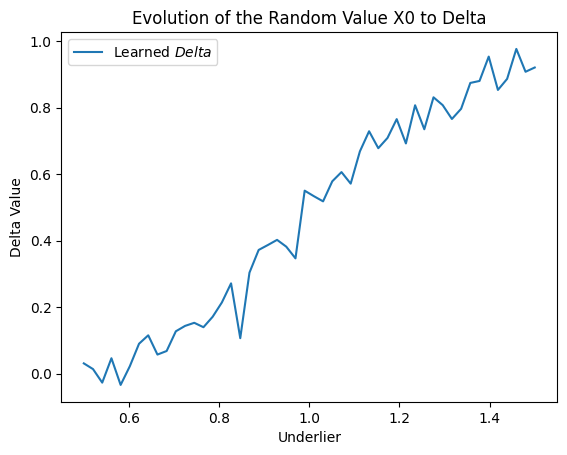

In [ ]:
plt.figure()
plt.plot(Xi.T, Z_pred_mean[-1,:].T, label='Learned $Delta$')
#plt.plot(Xi.T, _del.T, color='r', label='Exact $Delta$')
plt.xlabel('Underlier')
plt.ylabel('Delta Value')
plt.legend()
plt.title('Evolution of the Random Value X0 to Delta')
plt.savefig(str(D) + ' Random X0_Delta_2')

In [ ]:
from tabulate import tabulate
table = {'Xi': Xi.T, 'Z_mean': Z_pred_mean[-1, :].tolist(), 'Z_std': Z_pred_std[-1, :].tolist(), "Y0_exact": _del.T}
print(tabulate(table, headers='keys', tablefmt='github'))

|       Xi |     Z_mean |     Z_std |   Y0_exact |
|----------|------------|-----------|------------|
| 0.5      |  0.0306865 | 0.0236915 |   0.321561 |
| 0.520408 |  0.0134707 | 0.0305102 |   0.336026 |
| 0.540816 | -0.0272748 | 0.0369621 |   0.350168 |
| 0.561224 |  0.0461427 | 0.0570506 |   0.363986 |
| 0.581633 | -0.0341426 | 0.0765806 |   0.37748  |
| 0.602041 |  0.0221896 | 0.0911135 |   0.390652 |
| 0.622449 |  0.0898118 | 0.114922  |   0.403505 |
| 0.642857 |  0.115162  | 0.231742  |   0.416045 |
| 0.663265 |  0.0571992 | 0.156526  |   0.428274 |
| 0.683673 |  0.0679146 | 0.279297  |   0.440199 |
| 0.704082 |  0.127258  | 0.334157  |   0.451825 |
| 0.72449  |  0.143419  | 0.296548  |   0.463159 |
| 0.744898 |  0.152777  | 0.308526  |   0.474207 |
| 0.765306 |  0.139518  | 0.293457  |   0.484976 |
| 0.785714 |  0.17094   | 0.325272  |   0.495471 |
| 0.806122 |  0.213919  | 0.430668  |   0.505701 |
| 0.826531 |  0.271475  | 0.438764  |   0.515671 |
| 0.846939 |  0.106508  | 0.490

In [ ]:
delta_relative_error = np.abs(Z_pred_mean[-1, :] - _del)
print('Relative Error is: {}'.format(delta_relative_error))

Relative Error is: [[0.29087471 0.32255579 0.37744323 0.31784324 0.41162236 0.36846229
  0.3136937  0.30088205 0.37107465 0.37228424 0.32456734 0.31974003
  0.32143047 0.34545739 0.32453157 0.29178177 0.24419573 0.41888045
  0.23119443 0.17207537 0.16624682 0.15954191 0.18855127 0.23209079
  0.03651068 0.06102404 0.08435841 0.03152579 0.0111816  0.05311321
  0.03690888 0.09071274 0.03306115 0.05739884 0.10764112 0.02828318
  0.13711278 0.0589859  0.14936504 0.12015962 0.07297472 0.09829597
  0.17079874 0.17164485 0.23990432 0.13465659 0.16313971 0.24860556
  0.17526849 0.1836162 ]]
